# Startup with control and monitoring

This notebook test is implemented based upon [Startup with control and monitoring](https://skaoffice.jamacloud.com/perspective.req?docId=1121575&projectId=335).

References:
- [LOW.CSP LMC Documentation](https://developer.skatelescope.org/projects/ska-csp-lmc-low/en/latest/lmc/low_csp_lmc.html)
- [LOW.CSP LMC Tango Clients Examples](https://developer.skatelescope.org/projects/ska-csp-lmc-low/en/latest/example/example.html)
- [CSP LMC commands for AA05](https://confluence.skatelescope.org/display/SE/CSP+LMC+commands+for+AA05)

The LOW CSP release is deployed onto the Kubernetes (k8s) cluster as a software release with the underlying assumption that the CBF hardware is installed and available on the network.
After deployment the LOW CSP and associated subsystems are DISABLED and the TMC has to set the LOW CSP to adminMode=ONLINE to establish communication and enable command and control of the system.

Note: There is no direct ON command to LOW CSP. On the TMC command for adminMode=ONLINE controllers and subarrays for LOW CSP.LMC and LOW CBF will be in the ON state.
The PST and PSS beams (when available) will remain in OFF state.

The notebook will interrogate device states and report back attribute values as part of the verification output.    
For visual inspection of device attributes the Taranta API interface is used.    
You can access the interface via a web browser by pointing the URL to the appropriate namespace on your k8s cluster:

    http://<k8s_CLUSTER>/<KUBE_NAMESPACE>/taranta/devices/low-csp/

For example, to view the TANGO attributes for a deployment on the CLP, go to http://k8s.clp.skao.int/ska-low-csp-baseline/taranta/devices/low-csp/.


## Prerequisites

- All necessary equipment are installed and verified
- Assume a network is available and all equipment/systems are powered
- P4 switch is configured in order to control CBF
- Fresh deployment of LOW CSP on the k8s cluster

## Notebook settings

This section controls the settings used in this notebook.

### Imports

This section downloads and imports packages used in this notebook.

In [ ]:
%pip install --extra-index-url https://artefact.skao.int/repository/pypi-internal/simple pytango ska-control-model colorama

In [2]:
import json
import time

import tango
from colorama import Fore
from ska_control_model import AdminMode, HealthState, ObsState

from ska_low_csp_test.synchronisation import wait_for_condition

### Test environment

These settings configure the notebook to point to the correct environment where the system under test is deployed.
Make sure to update these settings to point to the correct TANGO database and Kubernetes cluster/namespace.

In [3]:
KUBE_CLUSTER_DOMAIN = "cluster.local"
KUBE_NAMESPACE = "ska-low-csp-dev"
TANGO_DATABASEDS_NAME = "ska-low-csp-databaseds"
TANGO_DATABASEDS_PORT = 10000

### Test settings

These settings configure the logic in the notebook.

Choose the `AdminMode` that is used to start up the system under test. Possible values:
- `AdminMode.ONLINE`
- `AdminMode.ENGINEERING`

## Notebook setup

### Define helper functions

In [4]:
def retrieve_device_proxies(device_class_name: str):
    """
    Query the TANGO database for devices exported for the given device class name.
    Returns TANGO device proxies for each exported device.
    """
    tango_db = tango.Database(f"{TANGO_DATABASEDS_NAME}.{KUBE_NAMESPACE}.svc.{KUBE_CLUSTER_DOMAIN}", TANGO_DATABASEDS_PORT)
    tango_host = f"tango://{TANGO_DATABASEDS_NAME}.{KUBE_NAMESPACE}.svc.{KUBE_CLUSTER_DOMAIN}:{TANGO_DATABASEDS_PORT}"
    device_fqdns = tango_db.get_device_exported_for_class(device_class_name).value_string

    print(device_class_name + ":")
    for fqdn in device_fqdns:
        print("  -", fqdn)
        yield tango.DeviceProxy(f"{tango_host}/{fqdn}")

In [5]:
# Coloured printing functions for strings that use universal ANSI escape sequences.
# fail: bold red, pass: bold green


def print_fail(message, start="", end="\n"):
    """Print coloured fail message."""
    print(f"{start}{Fore.RED}{message}{Fore.RESET}", end=end)


def print_pass(message, start="", end="\n"):
    """Print coloured pass message."""
    print(f"{start}{Fore.GREEN}{message}{Fore.RESET}", end=end)


def print_status(message: str, is_pass: bool, start="", end="\n"):
    """Print coloured status message."""
    print_func = print_pass if is_pass else print_fail
    print_func(message, start=start, end=end)


def wait_for_attribute_value(
    device,
    attr_name: str,
    attr_type,
    desired_value,
    timeout_s: float = 60,
) -> None:
    """Wait for an attribute to have the desired value.

    This function blocks the calling thread until the given attribute reaches the desired value
    or until a timeout occurs.

    :param attribute: The name of the attribute to read.
    :param desired_value: The desired value of the attribute.
    :param timeout_s: Number of seconds to wait before giving up.
    """
    print(f"{device}: Waiting for {attr_name} to become {desired_value}")
    print(device.read_attribute(attr_name, attr_type))
    print(desired_value)
    wait_for_condition(
        lambda: device.read_attribute(attr_name, attr_type) == desired_value,
        timeout_s=timeout_s,
    )

## Set up TANGO device proxies

Sets up a connection to the TANGO database and queries it for the TANGO devices that are exported.

The following device classes are expected to be present:
- `LowCspController`
- `LowCspSubarray`
- `LowCbfController`
- `LowCbfSubarray`
- `LowCbfProcessor`

In [ ]:
low_csp_controller = next(retrieve_device_proxies("LowCspController"))
low_csp_subarrays = list(retrieve_device_proxies("LowCspSubarray"))

low_cbf_controller = next(retrieve_device_proxies("LowCbfController"))
low_cbf_processors = list(retrieve_device_proxies("LowCbfProcessor"))
low_cbf_subarrays = list(retrieve_device_proxies("LowCbfSubarray"))
low_cbf_allocator = next(retrieve_device_proxies("LowCbfAllocator"))

## Set `adminMode` on LOW-CSP controller

In [26]:
ADMIN_MODE = AdminMode.ENGINEERING
low_csp_controller.adminMode = ADMIN_MODE
wait_for_condition(lambda: low_csp_controller.isCommunicating, timeout_s=60)

In [27]:
ar = {
    "interface": "https://schema.skao.int/ska-low-csp-assignresources/3.2",
    "common": {
        "subarray_id": 3,
    },
    "lowcbf": {},
}

conf = {
    "interface": "https://schema.skao.int/ska-low-csp-configure/3.2",
    "subarray": {
        "subarray_name": "ITC.L.AA0.5.CORR.2",
    },
    "common": {
        "config_id": 123456,
        "subarray_id": 3,
    },
    "lowcbf": {
        "stations": {
            "stns": [(345, 1), (431, 1)],
            "stn_beams": [
                {
                    "beam_id": 1,
                    "freq_ids": list(range(141, 149)),
                    "delay_poly": f"low-cbf/delaypoly/0/delay_s{3:02}_b{1:02}",
                },
            ],
        },
        "vis": {
            "fsp": {
                "firmware": "vis:0.0.7-main.0b854483:gitlab",
                "fsp_ids": [1],
            },
            "stn_beams": [
                {
                    "stn_beam_id": 1,
                    "host": [(0, "192.168.2.2")],
                    "mac": [(0, "0c-42-a1-9c-a2-1b")],
                    "port": [(0, 20000, 1)],
                    "integration_ms": 849,
                },
            ],
        },
    },
}

In [ ]:
subarray_under_test = low_cbf_subarrays[2]
controller = low_csp_controller
print(subarray_under_test)
print(controller)

In [ ]:
low_csp_controller.adminMode = AdminMode.OFFLINE

print("Waiting for LOW-CSP subarrays to turn off")
time.sleep(5)

low_csp_controller.adminMode = AdminMode.ONLINE
wait_for_condition(lambda: low_csp_controller.isCommunicating, timeout_s=60)

for subarray in low_csp_subarrays:
    print(subarray.state())
    wait_for_condition(lambda: subarray.state() == tango.DevState.ON, timeout_s=60)

print("Finished resetting system under test")

In [ ]:
print(subarray_under_test.obsState.name)
if subarray_under_test.obsState.name != "EMPTY":
    print("Abort")
    subarray_under_test.Abort()
    print("Restart")
    subarray_under_test.Restart()

In [32]:
subarray_under_test.assignResources(json.dumps(ar))
subarray_under_test.configure(json.dumps(conf))

subarray_under_test.adminMode = AdminMode.ENGINEERING
wait_for_condition(lambda: subarray_under_test.adminMode.value == 2, timeout_s=15)

In [33]:
assert subarray_under_test.adminMode == AdminMode.ENGINEERING

In [ ]:
subarray_under_test.Abort()
subarray_under_test.Restart()

subarray_under_test.adminMode = AdminMode.ONLINE
wait_for_condition(lambda: subarray_under_test.adminMode.value == 0, timeout_s=15)

controller.adminMode = AdminMode.ENGINEERING

for subarray in low_csp_subarrays:
    try:
        assert subarray.adminMode.name == "ENGINEERING"
    except:
        print(f"FAIL: {subarray} adminMode: {subarray.adminMode.name}")

for subarray in low_cbf_subarrays:
    try:
        assert subarray.adminMode.name == "ENGINEERING"
    except:
        print(f"FAIL: {subarray} adminMode: {subarray.adminMode.name}")

In [ ]:
print("Admin mode:")
for device in [low_csp_controller, low_cbf_controller, *low_csp_subarrays, *low_cbf_subarrays]:
    print_status(
        f"- {device.name()}/adminMode is {device.adminMode.name}/{device.adminMode.value}",
        is_pass=device.adminMode.name == "ENGINEERING",
    )

print("State:")
for device in [low_csp_controller, low_cbf_controller, *low_csp_subarrays, *low_cbf_subarrays]:
    print_status(f"- {device.name()}/state is {device.state()}", is_pass=device.state() == tango.DevState.ON)


print("Health state:")
for device in [low_csp_controller, low_cbf_controller, low_cbf_allocator, *low_csp_subarrays, *low_cbf_subarrays]:
    print_status(
        f"- {device.name()}/healthState is {device.healthState.name}/{device.healthState.value}",
        is_pass=device.healthState == HealthState.OK,
    )

print("Subarrays obsState:")
for device in [*low_csp_subarrays, *low_cbf_subarrays]:
    print_status(
        f"- {device.name()}/obsState is {device.obsState.name}/{device.obsState.value}",
        is_pass=device.obsState == ObsState.EMPTY,
    )

In [ ]:
low_csp_controller.adminMode = AdminMode.OFFLINE

print("Waiting for LOW-CSP subarrays to turn off")
time.sleep(5)

low_csp_controller.adminMode = AdminMode.ONLINE
wait_for_condition(lambda: low_csp_controller.isCommunicating, timeout_s=60)

for subarray in low_csp_subarrays:
    print(subarray.state())
    wait_for_condition(lambda: subarray.state() == tango.DevState.ON, timeout_s=60)

print("Finished resetting system under test")

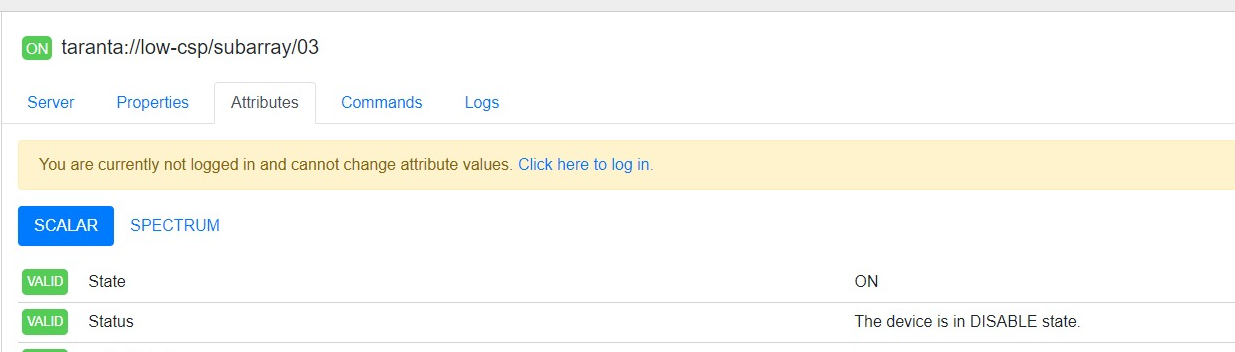

### Rerun is impossible because look at the screenshot